# Ammunition Time Series Forecasting and Prediction Using ARIMA, SARIMA, and SARIMAX
An in depth study into hourly ammunition price data.
#### <wyattcupp@gmail.com>
#### <wyattcupp@utexas.edu>

In [23]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stattools
import statsmodels.tsa.arima.model as models
import pmdarima as pm

from sklearn.metrics import mean_squared_error

import json

%matplotlib inline

In [3]:
# Turning off sklearn warnings that `pmdarima` cause
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%conda install -c conda-forge pmdarima 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.9.0
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


# ARIMA, SARIMA, SARIMAX

**ARIMA**
- `p`: Represents number of lag observations (lag order)
- `q`: Represents the size of the moving average window, or the order of the moving average component. This refers to the number of lagged forecast errors the model uses.

TODO: Add equations and relevant background information.

# Prediction and Forecasting Functions

In [96]:
def forecast(model, data: pd.DataFrame, periods=8760, plot=False):
    '''
    Forecasts the input model {periods} steps ahead.
    '''
    fc_index = pd.date_range(start=df_9_daily.index[-1], periods=periods, freq='D')
    fc = model.get_forecast(steps=periods, index=fc_index)
    df_forecast = fc.conf_int()
    df_forecast['pred'] = fc.predicted_mean

    if plot:
        plt.figure(figsize=(15,7))
        # plt.plot(data['ppr'].tail(270), color='#1f76b4')
        # plt.plot(data['pred'].tail(270), color='darkgreen')
        plt.plot(data['ppr'], color='#1f76b4')
        plt.plot(data['pred'], color='darkgreen')
        plt.plot(df_forecast['pred'], color='red')

        plt.fill_between(df_forecast['lower ppr'].index,
                         df_forecast['lower ppr'],
                         df_forecast['upper ppr'],
                         color='k', alpha=.15)
        plt.title('ARIMA PPR Forecast and Predictions')
        plt.show()

    return df_forecast

# 9mm

## ARIMA - No Seasonality

### Data & Preprocessing

In [4]:
# Load raw 9mm data scraped from AmmoPricesNow
nine_data_raw = None

with open('data/9mm_hourly.json') as f:
    nine_data_raw = json.load(f)

# spot check raw data
for date_, ppr in zip(nine_data_raw['categories'][:10], nine_data_raw['data'][:10]):
    print(date_, '->', ppr)

06/07/2020 06:00 -> 0.18
06/07/2020 07:00 -> 0.18
06/07/2020 08:00 -> 0.18
06/07/2020 09:00 -> 0.18
06/07/2020 10:00 -> 0.18
06/07/2020 11:00 -> 0.18
06/07/2020 12:00 -> 0.22
06/07/2020 13:00 -> 0.18
06/07/2020 14:00 -> 0.22
06/07/2020 15:00 -> 0.22


In [40]:
df_9 = pd.DataFrame(nine_data_raw).set_axis(['ppr', 'date_time'], axis=1)
df_9 = df_9.set_index('date_time')

# Remove duplicates
df_9 = df_9.reset_index().drop_duplicates(subset='date_time', keep='first').set_index('date_time')
df_9.index = pd.to_datetime(df_9.index)

# check for gaps in data
time_diffs = df_9.index.to_series().diff().dropna().unique()

if len(time_diffs) > 1:
    print(f'{len(time_diffs)} unevenly spaced data points found. Filling...')
    df_9 = df_9.resample('H').ffill()
    print('Successfully filled unevenly spaced data.')
    
df_9.index.freq = 'H'

# get houldout
train_size = int(len(df_9)*.85)
df_9, df_9_test = df_9.iloc[:train_size], df_9.iloc[train_size:]
df_9.head()

19 unevenly spaced data points found. Filling...
Successfully filled unevenly spaced data.


,ppr
date_time,
2020-06-07 06:00:00,0.18
2020-06-07 07:00:00,0.18
2020-06-07 08:00:00,0.18
2020-06-07 09:00:00,0.18
2020-06-07 10:00:00,0.18


In [41]:
df_9.describe()

,ppr
count,25710.000000
mean,0.336487
std,0.151742
min,0.000000
25%,0.220000
50%,0.300000
75%,0.460000
max,0.710000


In [42]:
# Calculate rolling weekly statistics for better visualization
df_9['rolling_mean'] = df_9['ppr'].rolling(168).mean()
df_9['rolling_std'] = df_9['ppr'].rolling(168).std()

df_9.sample(n=10, random_state=1)

,ppr,rolling_mean,rolling_std
date_time,,,
2020-06-16 21:00:00,0.25,0.220774,0.019668
2022-12-27 12:00:00,0.16,0.176071,0.014059
2021-01-27 09:00:00,0.61,0.694464,0.025354
2021-02-19 20:00:00,0.57,0.628810,0.043165
2021-10-15 20:00:00,0.32,0.326012,0.004911
2021-05-29 18:00:00,0.45,0.465476,0.023821
2020-09-13 02:00:00,0.34,0.523571,0.127422
2021-03-12 16:00:00,0.57,0.592440,0.017077
2021-10-05 05:00:00,0.34,0.338274,0.011160


In [43]:
# check if we are missing any data, and if so, impute it
df_9['ppr'].isna().sum()

0

### Analysis

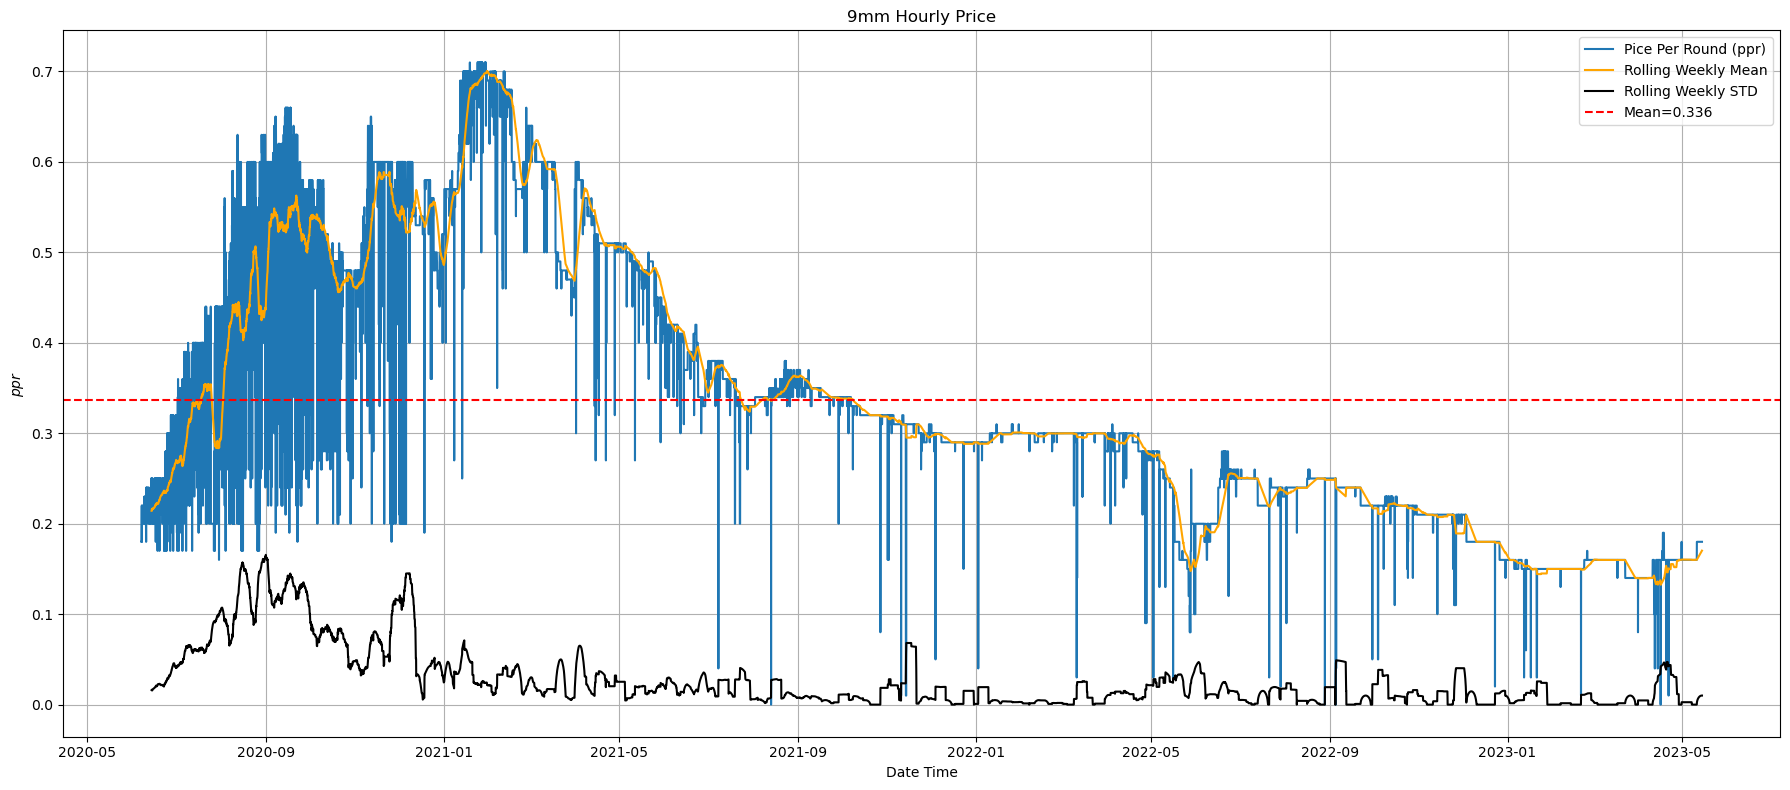

In [44]:
plt.figure(figsize=(18,8))

# plot ppr over time
plt.plot(df_9['ppr'], label='Pice Per Round (ppr)')
# plot weekly rolling average and std
plt.plot(df_9['rolling_mean'], color='orange', label='Rolling Weekly Mean')
plt.plot(df_9['rolling_std'], color='black', label='Rolling Weekly STD')

# plot the mean horizontally
plt.axhline(df_9['ppr'].mean(), color='r', ls='--', label=f'Mean={df_9["ppr"].mean():.3f}')

plt.title('9mm Hourly Price')
plt.legend()
plt.grid()

# Axis labels
plt.xlabel('Date Time')
plt.ylabel('$ppr$')

plt.tight_layout()
plt.show()

#### Augmented Dickey-Fuller Test (ADF)

Used to determine if time-series data is stationary or not.

**Null Hypothesis**: Data is not stationary.

**Alternative Hyptothesis**: Data *is* stationary.

**Significance Level**: 0.05

To reject the null hypothesis, the ADF test should have
- p-value <= 0.05

In [45]:
import statsmodels.tsa.stattools as stattools

#Augmented Dickey–Fuller test
adf_result_raw = stattools.adfuller(df_9['ppr'], autolag='AIC')

adf_result = {
    "Test Statistic": adf_result_raw[0],
    "p-value": adf_result_raw[1],
    "# Lags Used": adf_result_raw[2],
    "# Observations Used": adf_result_raw[3]
}

for k,v in adf_result_raw[4].items():
    adf_result[f'Critical Value ({k})'] = v

adf_result

{'Test Statistic': -1.97932276276907,
 'p-value': 0.29571228367394753,
 '# Lags Used': 49,
 '# Observations Used': 25660,
 'Critical Value (1%)': -3.430604869613817,
 'Critical Value (5%)': -2.8616526447803863,
 'Critical Value (10%)': -2.566829957500779}

Considering our p-value >=0.05, we can assume our data is not stationary.

#### ARIMA Model Parameter Selection

Even though our data is not stationary, we will first attempt to use an ARIMA model, which doesn't take into account seasonality using the following workflow:
- Use `pmdarima`'s `auto_arima` to pull the optimal `order` for our model.
- Fit a `statsmodels.tsa.arima.ARIMA` model using the optimized `order` found in the previous step.

In [46]:
# Auto-Arima model
auto_ARIMA = pm.auto_arima(df_9['ppr'], 
                      start_p=1,
                      start_q=1,
                      test='adf',
                      max_p=5, max_q=5, # We can afford this, since we aren't using seasonality
                      m=1,
                      d=None,
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-93799.983, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21716.637, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-9026.590, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=2.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-95126.738, Time=1.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-29169.687, Time=1.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-95040.873, Time=1.90 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-95268.453, Time=1.77 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-42462.680, Time=1.45 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-95137.554, Time=2.21 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-95444.777, Time=2.80 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-51225.971, Time=1.91 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-95337.644, Time=3.55 sec
 ARIMA(1,0,5)(0,0,0)[

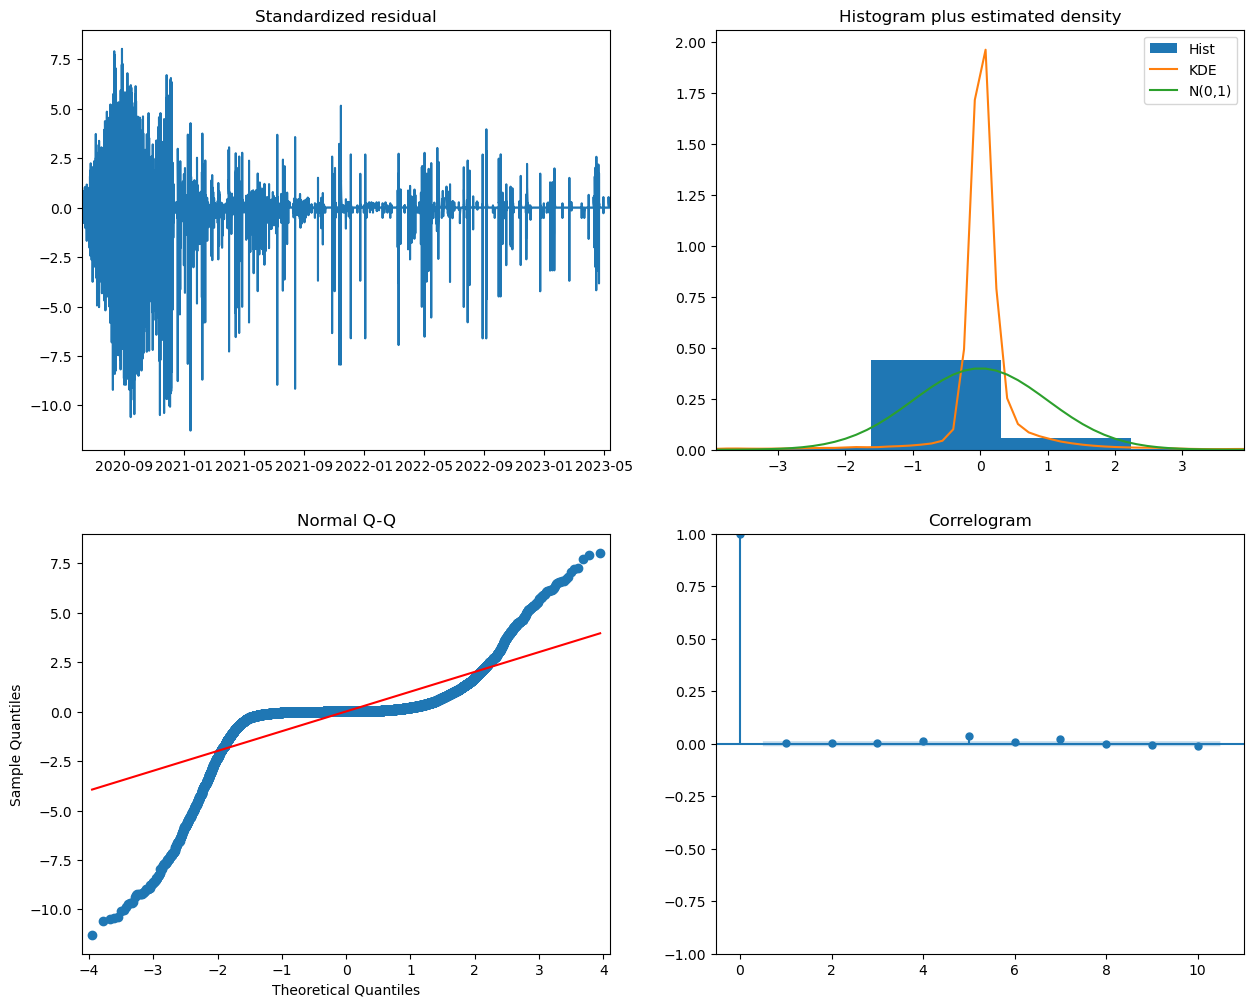

In [47]:
auto_ARIMA.plot_diagnostics(figsize=(15,12))
plt.show()

In [48]:
# check optimized order outputs (seasonal order should be zeros, since we are using ARIMA only and not SARIMA/SARIMAX)
auto_ARIMA.order, auto_ARIMA.seasonal_order

((1, 0, 5), (0, 0, 0, 0))

##### Now we fit an ARIMA base model using the optimized order from `auto_arima`

In [49]:
arima_model = models.ARIMA(df_9['ppr'], order=auto_ARIMA.order, seasonal_order=auto_ARIMA.seasonal_order)

arima_fitted = arima_model.fit()

arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    ppr   No. Observations:                25710
Model:                 ARIMA(1, 0, 5)   Log Likelihood               47753.927
Date:                Sun, 03 Dec 2023   AIC                         -95491.854
Time:                        21:07:13   BIC                         -95426.617
Sample:                    06-07-2020   HQIC                        -95470.767
                         - 05-14-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3314      0.049      6.707      0.000       0.235       0.428
ar.L1          0.9994      0.000   4569.246      0.000       0.999       1.000
ma.L1         -0.5946      0.002   -298.029      0.000      -0.599      -0.591
ma.L2         -0.1855      0.002    -81.760      0.000      -0.190      -0.181
ma.L3         -0.0186      0.002     -7.605      0.000      -0.023      -0.014
ma.L4         -0.0564      0.002    -22.694      0.000      -0.061      -0.051
ma.L5         -0.0420      0.002    -19.311      0.000      -0.046      -0.038
sigma2         0.0014   4.36e-06    327.106      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):           1053956.45
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                            -2.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### In-Sample Prediction

In [50]:
df_9['pred'] = arima_fitted.predict(start=df_9.index[0], end=df_9.index[-1], dynamic=False)

df_9.head()

,ppr,rolling_mean,rolling_std,pred
date_time,,,,
2020-06-07 06:00:00,0.18,NaN,NaN,0.331402
2020-06-07 07:00:00,0.18,NaN,NaN,0.191425
2020-06-07 08:00:00,0.18,NaN,NaN,0.187805
2020-06-07 09:00:00,0.18,NaN,NaN,0.185842
2020-06-07 10:00:00,0.18,NaN,NaN,0.185004


In [51]:
#RMSE
test_fc = arima_fitted.forecast(steps=len(df_9_test))

rmse_arima = math.sqrt(mean_squared_error(df_9_test['ppr'], test_fc))

rmse_arima

0.11407779822570625

In [74]:
def forecast_arima(model: models.ARIMA, data: pd.DataFrame, periods=8760, plot=False):
    fc_index = pd.date_range(start=df_9.index[-1], periods=periods, freq='H')
    fc = model.get_forecast(steps=periods, index=fc_index)
    df_forecast = fc.conf_int()
    df_forecast['pred'] = fc.predicted_mean

    if plot:
        plt.figure(figsize=(17,7))
        plt.plot(df_9['ppr'], color='#1f76b4', label='Original')
        plt.plot(df_9['pred'], color='darkgreen', label='In Sample Prediction')
        plt.plot(df_forecast['pred'], color='red', label='Forecast Predictions')

        plt.fill_between(df_forecast['lower ppr'].index,
                         df_forecast['lower ppr'],
                         df_forecast['upper ppr'],
                         color='k', alpha=.15)
        plt.title('ARIMA PPR Forecast and Predictions')
        plt.legend()
        plt.show()

    return df_forecast
        


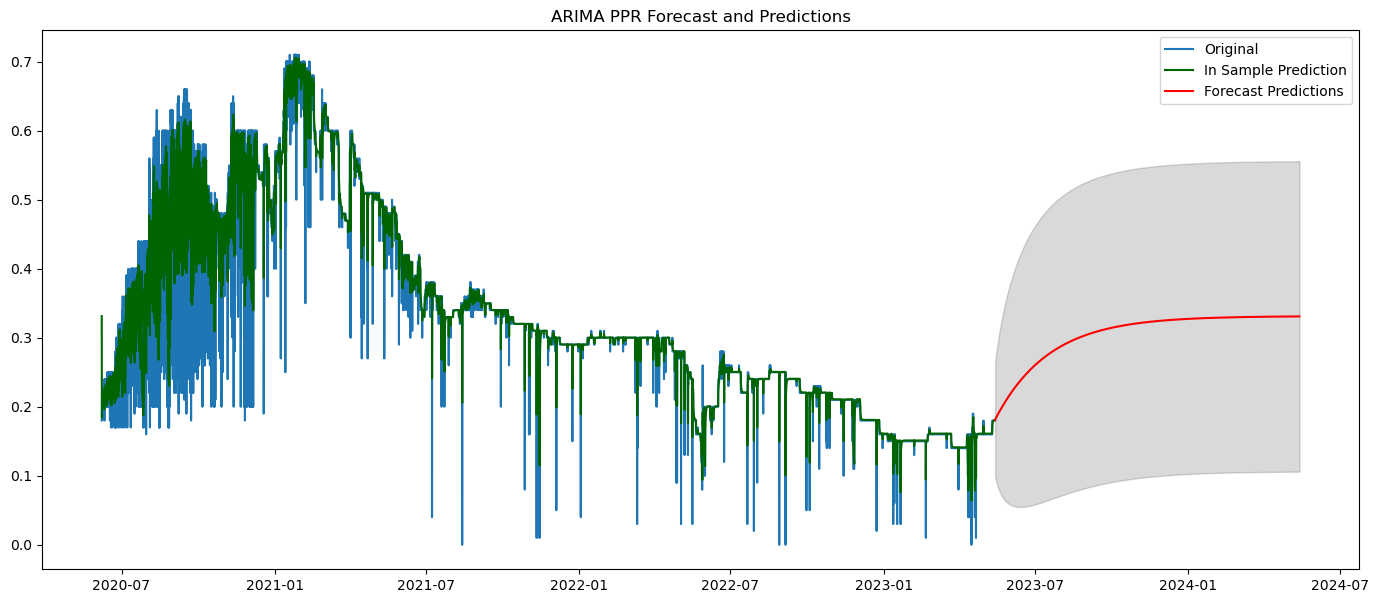

In [76]:
arima_forecast = forecast_arima(arima_fitted, data=df_9, plot=True)

## SARIMA Model - Incorporating Seasonality

### Data & Preprocessing

Since seasonal time-series models are extremely computationally expensive, we will be working with 9mm daily data instead of hourly due to our limited resources.

In [53]:
# Load raw 9mm data scraped from AmmoPricesNow
nine_daily_data_raw = None

with open('data/9mm_daily_data.json') as f:
    nine_daily_data_raw = json.load(f)

# spot check raw data
for date_, ppr in zip(nine_daily_data_raw['categories'][:10], nine_daily_data_raw['data'][:10]):
    print(date_, '->', ppr)

06/07/2020 -> 0.2
06/08/2020 -> 0.22
06/09/2020 -> 0.22
06/10/2020 -> 0.22
06/11/2020 -> 0.23
06/12/2020 -> 0.2
06/13/2020 -> 0.21
06/14/2020 -> 0.23
06/15/2020 -> 0.22
06/16/2020 -> 0.24


In [54]:
df_9_daily = pd.DataFrame(nine_daily_data_raw).set_axis(['ppr', 'date'], axis=1)
df_9_daily = df_9_daily.set_index('date')

# Remove duplicates
df_9_daily = df_9_daily.reset_index().drop_duplicates(subset='date', keep='first').set_index('date')
df_9_daily.index = pd.to_datetime(df_9_daily.index)

# check for gaps in data
time_diffs = df_9_daily.index.to_series().diff().dropna().unique()

if len(time_diffs) > 1:
    print(f'{len(time_diffs)} unevenly spaced data points found. Filling...')
    df_9 = df_9_daily.resample('D').ffill() # forward fill
    print('Successfully filled unevenly spaced data.')
    
df_9_daily.index.freq = 'D'

# get houldout
train_size = int(len(df_9_daily)*.85)
df_9_daily, df_9_daily_test = df_9_daily.iloc[:train_size], df_9_daily.iloc[train_size:]

df_9_daily.head()

,ppr
date,
2020-06-07,0.20
2020-06-08,0.22
2020-06-09,0.22
2020-06-10,0.22
2020-06-11,0.23


In [55]:
df_9_daily.describe()

,ppr
count,1082.000000
mean,0.334159
std,0.146842
min,0.090000
25%,0.220000
50%,0.300000
75%,0.460000
max,0.710000


In [56]:
# Calculate rolling weekly statistics for better visualization
df_9_daily['rolling_mean'] = df_9['ppr'].rolling(91).mean()
df_9_daily['rolling_std'] = df_9['ppr'].rolling(91).std()

df_9_daily.sample(n=10, random_state=1)

,ppr,rolling_mean,rolling_std
date,,,
2022-07-23,0.24,0.227143,0.024689
2022-05-07,0.26,0.276264,0.022194
2022-05-27,0.11,0.157582,0.004305
2022-08-21,0.25,0.250330,0.001795
2020-10-20,0.45,0.456374,0.085017
2020-09-14,0.56,0.538132,0.133848
2020-07-26,0.20,0.297143,0.091788
2021-10-01,0.33,0.338242,0.014802
2022-12-07,0.18,0.183187,0.008417


### Analysis

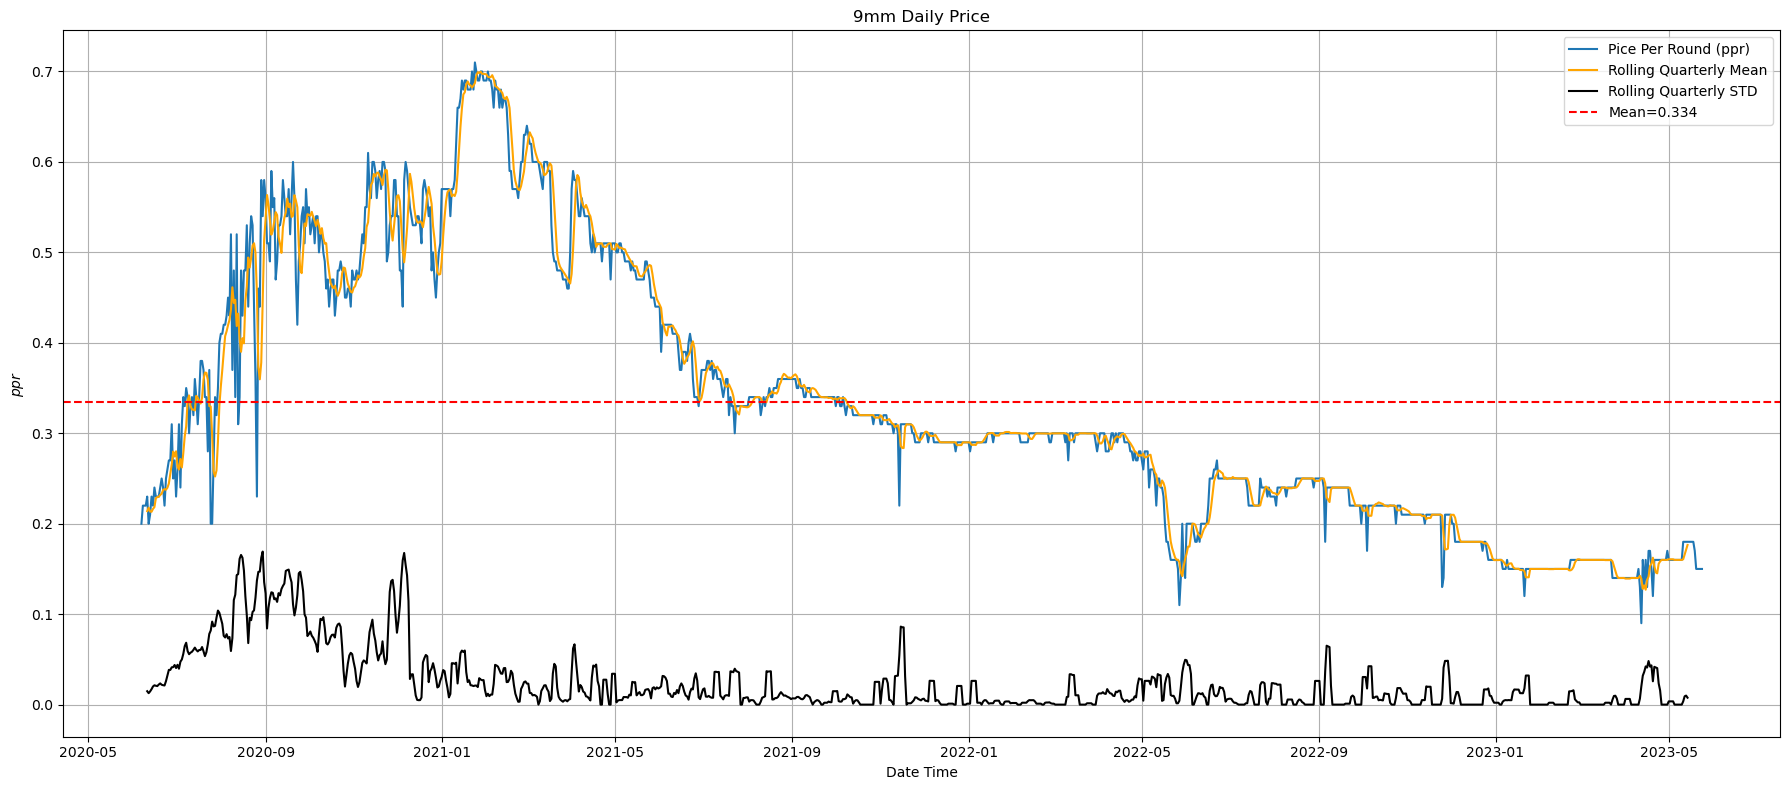

In [57]:
plt.figure(figsize=(18,8))

# plot ppr over time
plt.plot(df_9_daily['ppr'], label='Pice Per Round (ppr)')

# plot weekly rolling average and std
plt.plot(df_9_daily['rolling_mean'], color='orange', label='Rolling Quarterly Mean')
plt.plot(df_9_daily['rolling_std'], color='black', label='Rolling Quarterly STD')

# plot the mean horizontally
plt.axhline(df_9_daily['ppr'].mean(), color='r', ls='--', label=f'Mean={df_9_daily["ppr"].mean():.3f}')

plt.title('9mm Daily Price')
plt.legend()
plt.grid()

# Axis labels
plt.xlabel('Date Time')
plt.ylabel('$ppr$')

plt.tight_layout()
plt.show()

#### Augmented Dickey-Fuller Test (ADF)

Used to determine if time-series data is stationary or not.

**Null Hypothesis**: Data is not stationary.

**Alternative Hyptothesis**: Data *is* stationary.

**Significance Level**: 0.05

To reject the null hypothesis, the ADF test should have
- p-value <= 0.05

In [58]:
import statsmodels.tsa.stattools as stattools

#Augmented Dickey–Fuller test
adf_result_raw = stattools.adfuller(df_9_daily['ppr'], autolag='AIC')

adf_result = {
    "Test Statistic": adf_result_raw[0],
    "p-value": adf_result_raw[1],
    "# Lags Used": adf_result_raw[2],
    "# Observations Used": adf_result_raw[3]
}

for k,v in adf_result_raw[4].items():
    adf_result[f'Critical Value ({k})'] = v

adf_result

{'Test Statistic': -0.9497086909525801,
 'p-value': 0.7711624311350187,
 '# Lags Used': 19,
 '# Observations Used': 1062,
 'Critical Value (1%)': -3.4365224825380714,
 'Critical Value (5%)': -2.86426535058257,
 'Critical Value (10%)': -2.568221078163292}

#### Detect Seasonality

We must detect the potential seasonality periods for our data via seasonality tests.

In [59]:
import statsmodels.tsa.seasonal as seasonal

# First, we need to find the optimal seasonal periodicity of our data using seasonal decomposition
WEEK = 7
MONTH = 30
YEAR = 365
QUARTER = int(YEAR / 4)

seasonal_periods = [WEEK, MONTH, QUARTER, YEAR]

decompositions = {}
for period in seasonal_periods:
    result = seasonal.seasonal_decompose(df_9_daily['ppr'], model='additive', period=period)
    decompositions[period] = result

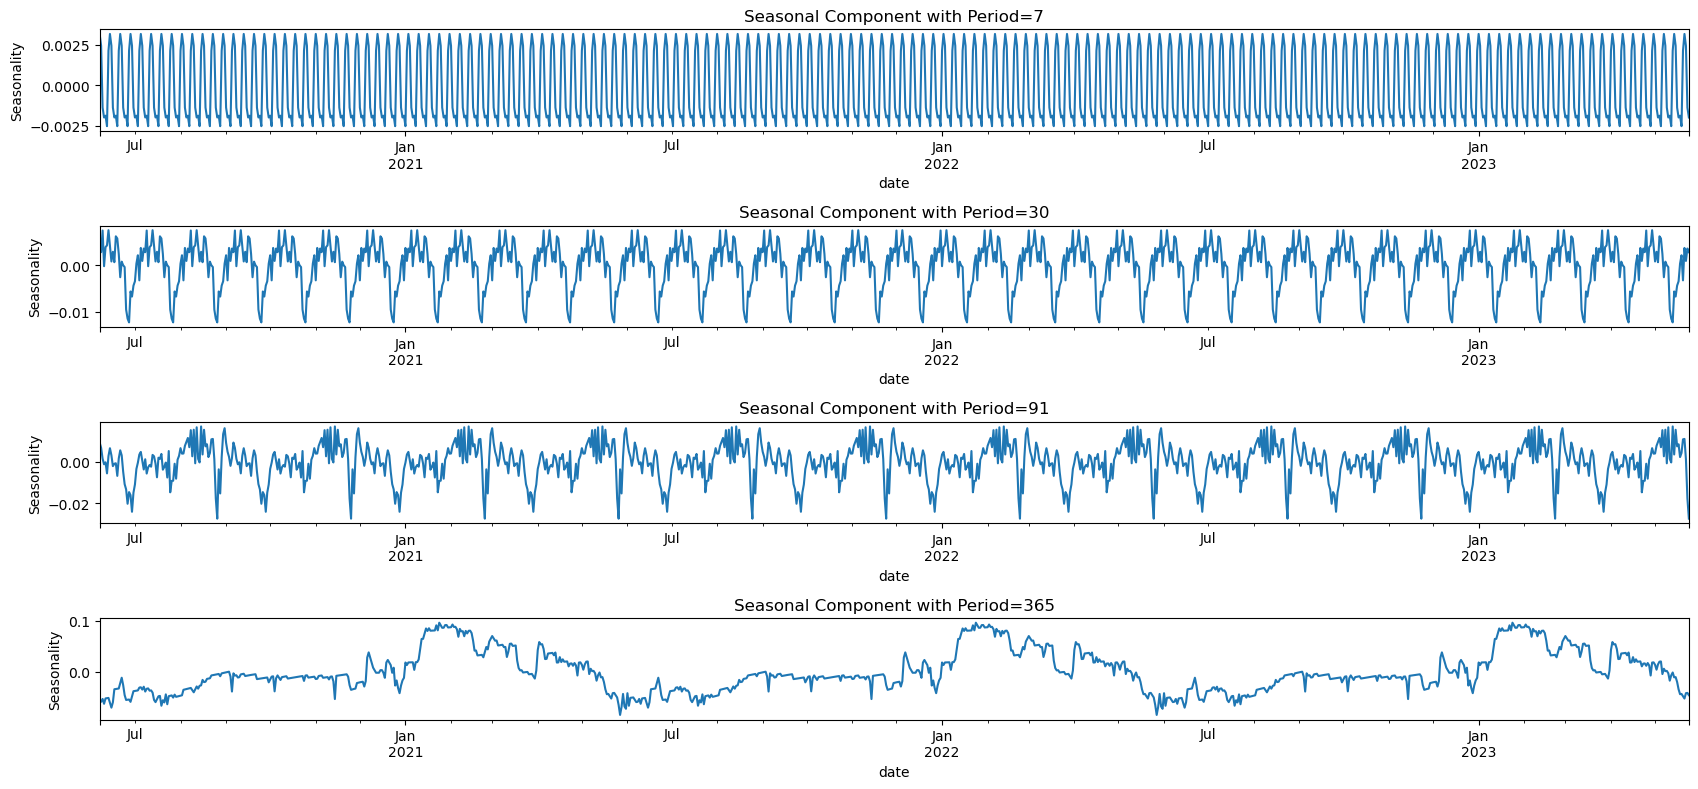

In [60]:
fig, axes = plt.subplots(nrows=len(seasonal_periods), figsize=(17, 8))

for i, period in enumerate(seasonal_periods):
    decompositions[period].seasonal.plot(ax=axes[i])
    axes[i].set_title(f'Seasonal Component with Period={period}')
    axes[i].set_ylabel('Seasonality')

plt.tight_layout()
plt.show()

#### SARIMA Model Parameter Selection for 30 Day Seasonality

In [61]:
# Seasonal - fit stepwise auto-ARIMA on daily
auto_SARIMA_30 = pm.auto_arima(df_9_daily['ppr'],
                            start_p=1,
                            start_q=1,
                            test='adf',
                            max_p=3,
                            max_q=3,
                            m=MONTH, # 30 day seasonal frequency
                            start_P=1,
                            start_Q=1,
                            seasonal=True, #set to seasonal
                            d=None, 
                            D=1,
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[30] intercept   : AIC=inf, Time=36.12 sec
 ARIMA(0,0,0)(0,1,0)[30] intercept   : AIC=-2815.760, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[30] intercept   : AIC=-4448.920, Time=15.33 sec
 ARIMA(0,0,1)(0,1,1)[30] intercept   : AIC=-3462.224, Time=15.47 sec
 ARIMA(0,0,0)(0,1,0)[30]             : AIC=-2816.316, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[30] intercept   : AIC=-4150.763, Time=1.29 sec
 ARIMA(1,0,0)(2,1,0)[30] intercept   : AIC=-4567.287, Time=1153.20 sec
 ARIMA(1,0,0)(2,1,1)[30] intercept   : AIC=inf, Time=498.44 sec
 ARIMA(1,0,0)(1,1,1)[30] intercept   : AIC=inf, Time=15.83 sec
 ARIMA(0,0,0)(2,1,0)[30] intercept   : AIC=-2826.839, Time=22.63 sec
 ARIMA(2,0,0)(2,1,0)[30] intercept   : AIC=-4669.510, Time=63.96 sec
 ARIMA(2,0,0)(1,1,0)[30] intercept   : AIC=-4543.202, Time=18.81 sec
 ARIMA(2,0,0)(2,1,1)[30] intercept   : AIC=inf, Time=78.88 sec
 ARIMA(2,0,0)(1,1,1)[30] intercept   : AIC=inf, Time=27.21 sec
 ARIMA(3,0,0)(2,1,0)[

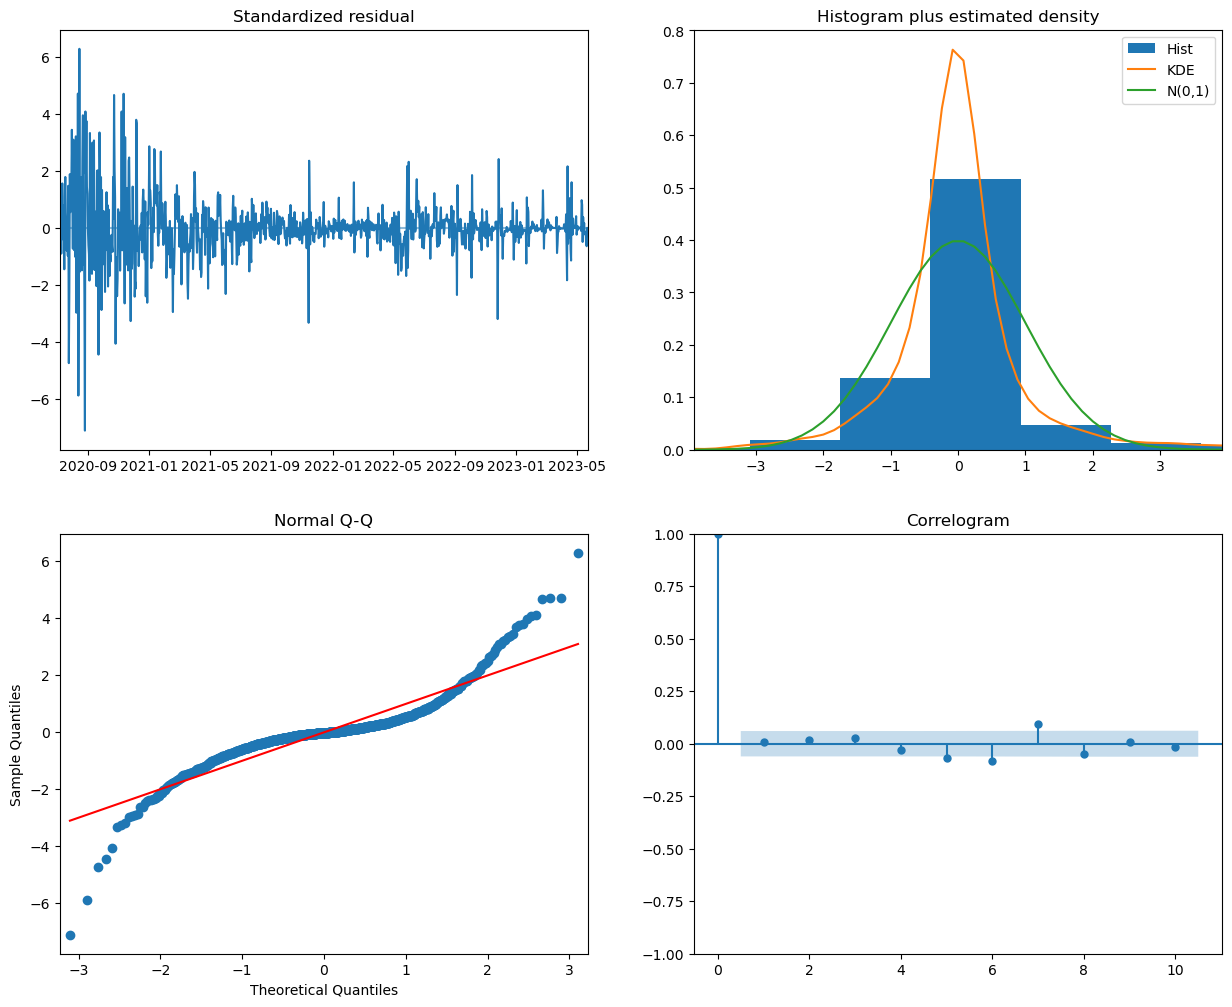

In [65]:
auto_SARIMA_30.plot_diagnostics(figsize=(15,12))
plt.show()

#### Using the Order Params Found by `auto_arima`, Fit the SARIMA Model

In [66]:
auto_SARIMA_30.order, auto_SARIMA_30.seasonal_order

((2, 0, 3), (2, 1, 0, 30))

In [67]:
import statsmodels.tsa.statespace.sarimax as sarima

sarima_30_model = sarima.SARIMAX(df_9_daily['ppr'],
                       order = auto_SARIMA_30.order,
                       seasonal_order=auto_SARIMA_30.seasonal_order)

sarima_30_fitted = sarima_30_model.fit()

sarima_30_fitted.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.03087D+00    |proj g|=  3.10847D+00


 This problem is unconstrained.



At iterate    5    f= -2.03564D+00    |proj g|=  2.45159D+00

At iterate   10    f= -2.14350D+00    |proj g|=  6.26965D+00

At iterate   15    f= -2.15046D+00    |proj g|=  5.58338D-01

At iterate   20    f= -2.16088D+00    |proj g|=  3.95584D+00

At iterate   25    f= -2.16825D+00    |proj g|=  1.04046D-01

At iterate   30    f= -2.17169D+00    |proj g|=  5.20724D-02

At iterate   35    f= -2.17398D+00    |proj g|=  1.53259D+00

At iterate   40    f= -2.17541D+00    |proj g|=  4.28161D-02

At iterate   45    f= -2.17838D+00    |proj g|=  1.50677D-02

At iterate   50    f= -2.17863D+00    |proj g|=  7.14080D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/wyattcupp/miniconda3/envs/ds-py311/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 ppr   No. Observations:                 1082
Model:             SARIMAX(2, 0, 3)x(2, 1, [], 30)   Log Likelihood                2357.277
Date:                             Sun, 03 Dec 2023   AIC                          -4698.554
Time:                                     22:11:27   BIC                          -4658.886
Sample:                                 06-07-2020   HQIC                         -4683.515
                                      - 05-24-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5456      0.073      7.493      0.000       0.403       0.688
ar.L2          0.4311      0.072      6.024      0.000       0.291       0.571
ma.L1          0.0791      0.075      1.051      0.293      -0.068       0.227
ma.L2         -0.1454      0.036     -4.014      0.000      -0.216      -0.074
ma.L3         -0.2051      0.018    -11.274      0.000      -0.241      -0.169
ar.S.L30      -0.7166      0.018    -38.810      0.000      -0.753      -0.680
ar.S.L60      -0.3839      0.016    -24.680      0.000      -0.414      -0.353
sigma2         0.0007   1.29e-05     50.472      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              3550.72
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
df_9_daily['pred_30'] = sarima_30_fitted.predict(start=df_9_daily.index[0], end=df_9_daily.index[-1])

df_9_daily

,ppr,rolling_mean,rolling_std,pred_30
date,,,,
2020-06-07,0.20,NaN,NaN,0.000000e+00
2020-06-08,0.22,NaN,NaN,7.073611e-10
2020-06-09,0.22,NaN,NaN,1.442930e-09
2020-06-10,0.22,NaN,NaN,2.110867e-09
2020-06-11,0.23,0.213956,0.014823,2.761958e-09
...,...,...,...,...
2023-05-20,0.15,NaN,NaN,1.644104e-01
2023-05-21,0.15,NaN,NaN,1.663125e-01
2023-05-22,0.15,NaN,NaN,1.498898e-01


In [70]:
# RMSE
test_fc = sarima_30_fitted.forecast(steps=len(df_9_daily_test))

rmse_sarima = math.sqrt(mean_squared_error(df_9_daily_test['ppr'], test_fc))

rmse_sarima

0.027756603020140495

In [71]:
def forecast_sarima(model, data: pd.DataFrame, periods=30, plot=False, title='SARIMA PPR Forecast and Predictions'):
    fc_index = pd.date_range(start=df_9_daily.index[-1], periods=periods, freq='D')
    fc = model.get_forecast(steps=periods, index=fc_index)
    df_forecast = fc.conf_int()
    df_forecast['pred'] = fc.predicted_mean

    if plot:
        plt.figure(figsize=(15,7))
        plt.plot(data['ppr'].tail(periods*2), color='#1f76b4', label='Original')
        plt.plot(data['pred_30'].tail(periods*2), color='darkgreen', label='In-Sample Prediction')
        plt.plot(df_forecast['pred'], color='red', label='Forecast Prediction')

        plt.fill_between(df_forecast['lower ppr'].index,
                         df_forecast['lower ppr'],
                         df_forecast['upper ppr'],
                         color='k', alpha=.15)

        plt.title(title)
        plt.legend()
        plt.ylabel('$ppr$')
        plt.xlabel('Date')
        plt.show()

    return df_forecast

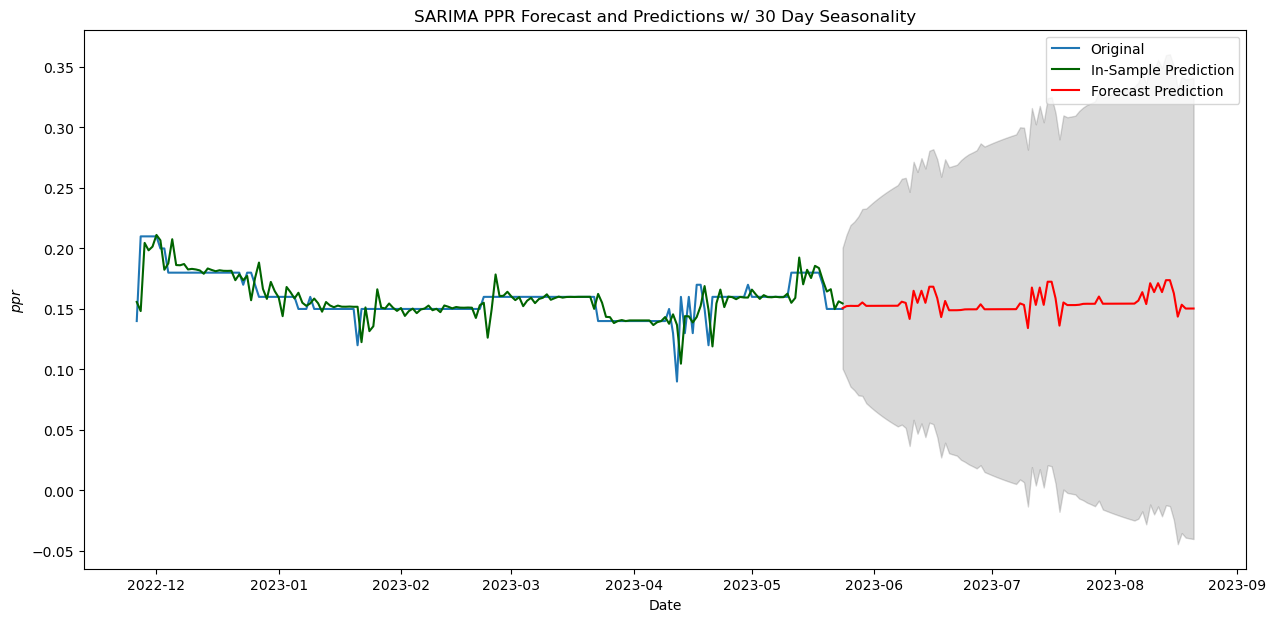

In [73]:
sarima_forecast = forecast_sarima(sarima_30_fitted, data=df_9_daily, periods=90, plot=True, title='SARIMA PPR Forecast and Predictions w/ 30 Day Seasonality')
# sarima_forecast.head()

#### 

In [ ]:
# Seasonal - fit stepwise auto-ARIMA on daily
auto_SARIMA_quarterly = pm.auto_arima(df_9_daily['ppr'],
                            start_p=1,
                            start_q=1,
                            test='adf',
                            max_p=2, max_q=2, # to save computational time due to large seasonality period
                            m=QUARTER, # quarterly seasonality
                            start_P=1,
                            start_Q=1,
                            seasonal=True, #set to seasonal
                            d=None, 
                            D=1,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[91] intercept   : AIC=inf, Time=227.64 sec
 ARIMA(0,0,0)(0,1,0)[91] intercept   : AIC=-2229.528, Time=12.55 sec
 ARIMA(1,0,0)(1,1,0)[91] intercept   : AIC=inf, Time=79.65 sec
 ARIMA(0,0,1)(0,1,1)[91] intercept   : AIC=-3294.622, Time=197.15 sec
 ARIMA(0,0,0)(0,1,0)[91]             : AIC=-2209.467, Time=3.53 sec
 ARIMA(0,0,1)(0,1,0)[91] intercept   : AIC=-3296.057, Time=36.47 sec
 ARIMA(0,0,1)(1,1,0)[91] intercept   : AIC=-3294.405, Time=326.91 sec
 ARIMA(0,0,1)(1,1,1)[91] intercept   : AIC=inf, Time=197.19 sec
 ARIMA(1,0,1)(0,1,0)[91] intercept   : AIC=-5296.211, Time=33.56 sec
 ARIMA(1,0,1)(1,1,0)[91] intercept   : AIC=-5465.272, Time=304.55 sec
 ARIMA(1,0,1)(2,1,0)[91] intercept   : AIC=-5502.238, Time=586.42 sec
 ARIMA(1,0,1)(2,1,1)[91] intercept   : AIC=inf, Time=940.52 sec


In [ ]:
auto_SARIMA_quarterly.plot_diagnostics(figsize=(15,12))

#### Using the Order Params Found by `auto_arima`, Fit the Quarterly SARIMA Model

In [ ]:
auto_SARIMA_quarterly.order, auto_SARIMA_quarterly.seasonal_order

In [ ]:
sarima_60_model = sarima.SARIMAX(df_9_daily['ppr'],
                       order = auto_SARIMA_quarterly.order, # fitted order params
                       seasonal_order=auto_SARIMA_quarterly.seasonal_order) # fitted seasonal order params

sarima_60_fitted = sarima_model.fit()

sarima_60_fitted.summary()

## 223 Remington

### Data

In [ ]:
rem_data_raw = None

with open('data/223rem_hourly.json') as f:
    rem_data_raw = json.load(f)

# spot check raw data
for date_, ppr in zip(rem_data_raw['categories'][:10], rem_data_raw['data'][:10]):
    print(date_, '->', ppr)

In [ ]:
df_223 = pd.DataFrame(rem_data_raw).set_axis(['ppr', 'date_time'], axis=1)
df_223['date_time'] = pd.to_datetime(df_223['date_time'])
df_223 = df_223.set_index('date_time')

df_223.head()

In [ ]:
df_223.describe()

In [ ]:
# Calculate rolling weekly statistics for better visualization
df_223['rolling_mean'] = df_223['ppr'].rolling(168).mean()
df_223['rolling_std'] = df_223['ppr'].rolling(168).std()

df_223.sample(n=10, random_state=1)

In [ ]:
plt.figure(figsize=(15,7))

# plot ppr over time
plt.plot(df_223['ppr'], label='Pice Per Round (ppr)')
# plot weekly rolling average and std
plt.plot(df_223['rolling_mean'], color='orange', label='Rolling Weekly Mean')
plt.plot(df_223['rolling_std'], color='black', label='Rolling Weekly STD')

# plot the mean horizontally
plt.axhline(df_223['ppr'].mean(), color='r', ls='--', label=f'Mean={df_223["ppr"].mean():.3f}')

plt.title('223 Remington Hourly Price')
plt.legend()
plt.grid()

# Axis labels
plt.xlabel('Date Time')
plt.ylabel('$ppr$')

plt.tight_layout()
plt.show()

## 556 NATO

### Data

In [ ]:
nato_data_raw = None

with open('data/556nato_hourly.json') as f:
    nato_data_raw = json.load(f)

# spot check raw data
for date_, ppr in zip(nato_data_raw['categories'][:10], nato_data_raw['data'][:10]):
    print(date_, '->', ppr)

In [ ]:
df_556 = pd.DataFrame(nato_data_raw).set_axis(['ppr', 'date_time'], axis=1)
df_556['date_time'] = pd.to_datetime(df_556['date_time'])
df_556 = df_556.set_index('date_time')

df_556.head()

In [ ]:
df_556.describe()

In [ ]:
# Calculate rolling weekly statistics for better visualization
df_556['rolling_mean'] = df_556['ppr'].rolling(168).mean()
df_556['rolling_std'] = df_556['ppr'].rolling(168).std()

df_556.sample(n=10, random_state=1)

In [ ]:
df_556['ppr'].isna().sum()

In [ ]:
# 556
plt.figure(figsize=(15,7))

# plot ppr over time
plt.plot(df_556['ppr'], label='Pice Per Round (ppr)')
# plot weekly rolling average and std
plt.plot(df_556['rolling_mean'], color='orange', label='Rolling Weekly Mean')
plt.plot(df_556['rolling_std'], color='black', label='Rolling Weekly STD')

# plot the mean horizontally
plt.axhline(df_556['ppr'].mean(), color='r', ls='--', label=f'Mean={df_556["ppr"].mean():.3f}')

plt.title('556 NATO Remington Hourly Price')
plt.legend()
plt.grid()

# Axis labels
plt.xlabel('Date Time')
plt.ylabel('$ppr$')

plt.tight_layout()
plt.show()